In [6]:
!pip -q install clickhouse-connect==0.6.11 transformers tokenizers torch torchvision sentencepiece protobuf

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [153]:
import clickhouse_connect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List

In [2]:
client = clickhouse_connect.get_client(
    host="clickhouse",
    port=8123,
    username="clickhouse-user",
    password="secret"
)

In [3]:
query = """CREATE TABLE IF NOT EXISTS messages
(
    id                String,
    type              String,
    message           String,
    timestamp         Int64,
    datetime          String,
    elapsedTime       String,
    amountValue       Float32,
    amountString      String,
    currency          String,
    author_name       String,
    author_channelId  String,
    author_channelUrl String,
    video_id          String,
    stream_name       String
) ENGINE = MergeTree()
ORDER BY (timestamp);
"""

In [4]:
client.command(query)

In [8]:
data = {
    'id': 'ChwKGkNJcjhwWmlma29FREZiM0R3Z1FkT3VjTC1R', 
    'type': 'textMessage', 
    'message': 'lastima. Pinta de pokemones tienen jajaj', 
    'timestamp': 1693874754555, 
    'datetime': '2023-09-05 00:45:54', 
    'elapsedTime': '', 
    'amountValue': 0.0, 
    'amountString': '', 
    'currency': '', 
    'author_name': 'FerClonazepum!', 
    'author_channelId': 'UCIguRa3t5CYgm1ai_OuZq8A', 
    'author_channelUrl': 'http://www.youtube.com/channel/UCIguRa3t5CYgm1ai_OuZq8A',
    "video_id": "some_id",
    "stream_name": "TN"
}

In [28]:
data.keys()

dict_keys(['id', 'type', 'message', 'timestamp', 'datetime', 'elapsedTime', 'amountValue', 'amountString', 'currency', 'author_name', 'author_channelId', 'author_channelUrl'])

In [9]:
to_insert = data.values()
to_insert

dict_values(['ChwKGkNJcjhwWmlma29FREZiM0R3Z1FkT3VjTC1R', 'textMessage', 'lastima. Pinta de pokemones tienen jajaj', 1693874754555, '2023-09-05 00:45:54', '', 0.0, '', '', 'FerClonazepum!', 'UCIguRa3t5CYgm1ai_OuZq8A', 'http://www.youtube.com/channel/UCIguRa3t5CYgm1ai_OuZq8A'])

In [8]:
result = client.query("DESCRIBE TABLE messages")
result.result_rows

[('id', 'String', '', '', '', '', ''),
 ('type', 'String', '', '', '', '', ''),
 ('message', 'String', '', '', '', '', ''),
 ('timestamp', 'Int64', '', '', '', '', ''),
 ('datetime', 'String', '', '', '', '', ''),
 ('elapsedTime', 'String', '', '', '', '', ''),
 ('amountValue', 'Float32', '', '', '', '', ''),
 ('amountString', 'String', '', '', '', '', ''),
 ('currency', 'String', '', '', '', '', ''),
 ('author_name', 'String', '', '', '', '', ''),
 ('author_channelId', 'String', '', '', '', '', ''),
 ('author_channelUrl', 'String', '', '', '', '', ''),
 ('video_id', 'String', '', '', '', '', ''),
 ('stream_name', 'String', '', '', '', '', '')]

In [30]:
client.insert("messages", [[x for x in data.values()]], column_names=[x for x in data.keys()])

In [138]:
grouped_by_hour_query = """SELECT 
    stream_name, 
    toHour(toTimeZone(toDateTime(datetime), 'America/Argentina/Buenos_Aires')) as hour, 
    COUNT(*) as cnt 
FROM messages 
GROUP BY stream_name, hour
"""
cnt = client.query(grouped_by_hour_query)
cnt.result_rows

[('TN', 9, 669),
 ('TN', 8, 770),
 ('TN', 12, 730),
 ('TN', 13, 1264),
 ('A24', 16, 569),
 ('C5N', 21, 7655),
 ('C5N', 20, 6659),
 ('A24', 17, 738),
 ('TN', 6, 197),
 ('TN', 7, 820),
 ('TN', 3, 15),
 ('TN', 2, 69),
 ('A24', 21, 3921),
 ('C5N', 16, 2204),
 ('C5N', 17, 2018),
 ('A24', 20, 2468),
 ('TN', 23, 3156),
 ('TN', 22, 5750),
 ('A24', 1, 100),
 ('C5N', 4, 118),
 ('C5N', 5, 11),
 ('A24', 0, 670),
 ('A24', 4, 6),
 ('C5N', 1, 407),
 ('C5N', 0, 1050),
 ('A24', 5, 3),
 ('TN', 18, 3101),
 ('TN', 19, 2842),
 ('A24', 14, 65),
 ('C5N', 11, 966),
 ('C5N', 10, 1148),
 ('A24', 15, 594),
 ('A24', 11, 289),
 ('C5N', 14, 1099),
 ('C5N', 15, 1951),
 ('A24', 10, 577),
 ('A24', 8, 356),
 ('C5N', 13, 1219),
 ('C5N', 12, 845),
 ('A24', 9, 584),
 ('A24', 13, 423),
 ('C5N', 8, 947),
 ('C5N', 9, 896),
 ('A24', 12, 308),
 ('A24', 7, 272),
 ('C5N', 2, 261),
 ('C5N', 3, 357),
 ('A24', 6, 12),
 ('TN', 17, 1831),
 ('TN', 16, 1959),
 ('TN', 20, 3767),
 ('TN', 21, 4057),
 ('A24', 2, 3),
 ('C5N', 7, 469),
 ('C5

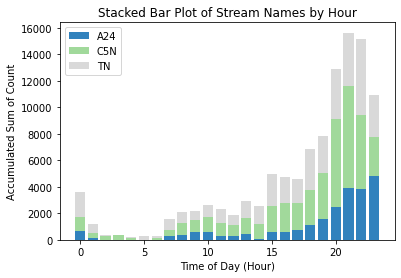

In [139]:
# Extract unique hours and stream_names
hours = sorted(set(item[1] for item in cnt.result_rows))
stream_names = sorted(set(item[0] for item in cnt.result_rows))

# Create a dictionary to store the data for each stream_name
stream_data = {stream_name: [0] * len(hours) for stream_name in stream_names}

# Populate the data dictionary
for stream_name, hour, count in cnt.result_rows:
    stream_data[stream_name][hours.index(hour)] += count

# Create a list of colors for stacking bars
colors = plt.cm.get_cmap('tab20c', len(stream_names))

# Create the bar plot
fig, ax = plt.subplots()
bottom = np.zeros(len(hours))

for i, stream_name in enumerate(stream_names):
    ax.bar(hours, stream_data[stream_name], label=stream_name, bottom=bottom, color=colors(i))
    bottom += np.array(stream_data[stream_name])

# Set labels and legend
ax.set_xlabel('Time of Day (Hour)')
ax.set_ylabel('Accumulated Sum of Count')
ax.set_title('Stacked Bar Plot of Stream Names by Hour')
ax.legend()

# Show the plot
plt.show()

In [147]:
def plot_by_channel(channel: str):
    grouped_by_hour_query = f"""SELECT 
        stream_name, 
        toHour(toTimeZone(toDateTime(datetime), 'America/Argentina/Buenos_Aires')) as hour, 
        COUNT(*) as cnt 
    FROM messages 
    WHERE stream_name='{channel}'
    GROUP BY stream_name, hour
    """
    cnt = client.query(grouped_by_hour_query)
    cnt.result_rows
    
    # Extract unique hours and stream_names
    hours = sorted(set(item[1] for item in cnt.result_rows))
    stream_names = sorted(set(item[0] for item in cnt.result_rows))

    # Create a dictionary to store the data for each stream_name
    stream_data = {stream_name: [0] * len(hours) for stream_name in stream_names}

    # Populate the data dictionary
    for stream_name, hour, count in cnt.result_rows:
        stream_data[stream_name][hours.index(hour)] += count

    # Create a list of colors for stacking bars
    colors = plt.cm.get_cmap('tab20c', len(stream_names))

    # Create the bar plot
    fig, ax = plt.subplots()
    bottom = np.zeros(len(hours))

    for i, stream_name in enumerate(stream_names):
        ax.bar(hours, stream_data[stream_name], label=stream_name, bottom=bottom, color=colors(i))
        bottom += np.array(stream_data[stream_name])

    # Set labels and legend
    ax.set_xlabel('Time of Day (Hour)')
    ax.set_ylabel('Accumulated Sum of Count')
    ax.set_title('Stacked Bar Plot of Stream Names by Hour')
    ax.legend()

    # Show the plot
    plt.show()

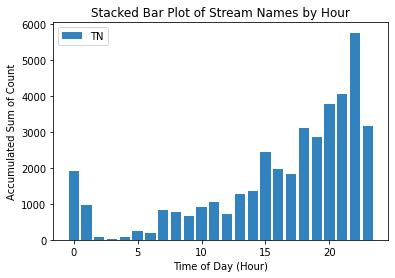

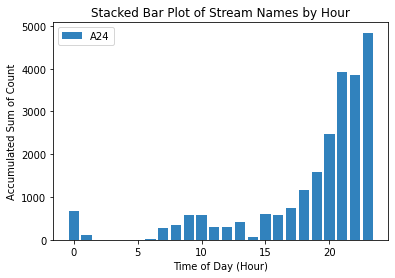

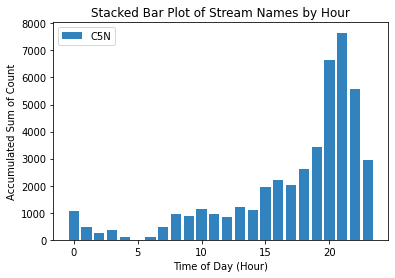

In [149]:
plot_by_channel("TN")
plot_by_channel("A24")
plot_by_channel("C5N")

In [150]:
sentiment_per_strem = client.query("""SELECT m.stream_name, sentiment_label, COUNT(*) as cnt FROM sentiment s JOIN messages m ON m.id = s.id GROUP BY m.stream_name, sentiment_label""").result_rows
sentiment_per_strem

[('C5N', 'positive', 1359),
 ('A24', 'positive', 794),
 ('TN', 'positive', 1197),
 ('C5N', 'negative', 8597),
 ('C5N', 'neutral', 5549),
 ('A24', 'neutral', 2513),
 ('A24', 'negative', 3978),
 ('TN', 'negative', 6069),
 ('TN', 'neutral', 5057)]

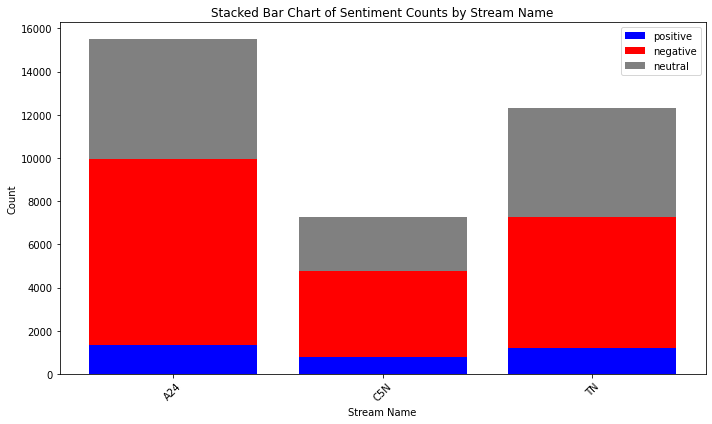

In [151]:
# Separate data by sentiment
positive_data = [entry for entry in sentiment_per_strem if entry[1] == 'positive']
negative_data = [entry for entry in sentiment_per_strem if entry[1] == 'negative']
neutral_data = [entry for entry in sentiment_per_strem if entry[1] == 'neutral']

# Extract stream names and counts for each sentiment
stream_names = [entry[0] for entry in sentiment_per_strem]
positive_counts = [entry[2] for entry in positive_data]
negative_counts = [entry[2] for entry in negative_data]
neutral_counts = [entry[2] for entry in neutral_data]

# Create a unique list of stream names
unique_stream_names = list(set(stream_names))

# Sort the stream names alphabetically
unique_stream_names.sort()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color mapping for sentiments
colors = {'positive': 'blue', 'negative': 'red', 'neutral': 'gray'}

# Initialize the bottom values for stacking
bottom = np.zeros(len(unique_stream_names))

# Plot each sentiment as a stacked bar
for sentiment in ['positive', 'negative', 'neutral']:
    counts = [entry[2] for entry in sentiment_per_strem if entry[1] == sentiment]
    color = colors[sentiment]
    ax.bar(
        unique_stream_names,
        counts,
        label=sentiment,
        color=color,
        bottom=bottom,
    )
    bottom = np.add(bottom, counts)

# Set labels and legend
ax.set_xlabel('Stream Name')
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Chart of Sentiment Counts by Stream Name')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [154]:
def sentiment_per_party(words: List[str], candidate_name: str):
    ored_words = "|".join(words)
    q = f"""SELECT stream_name, sentiment_label, COUNT(*) as cnt, match(message, '{ored_words}') as is_candidate FROM messages m JOIN sentiment s ON s.id = m.id WHERE is_candidate GROUP BY stream_name, sentiment_label, is_candidate"""
    milei_sentiment_per_channel = client.query(q).result_rows
    
    # Create dictionaries to store data for each category
    positive_data = {}
    neutral_data = {}
    negative_data = {}
    total_data = {}

    for channel, sentiment, count, _ in milei_sentiment_per_channel:
        if channel in total_data:
            total_data[channel] += count
        else:
            total_data[channel] = count

        if sentiment == 'positive':
            if channel in positive_data:
                positive_data[channel] += count
            else:
                positive_data[channel] = count
        elif sentiment == 'neutral':
            if channel in neutral_data:
                neutral_data[channel] += count
            else:
                neutral_data[channel] = count
        elif sentiment == 'negative':
            if channel in negative_data:
                negative_data[channel] += count
            else:
                negative_data[channel] = count

    channels = list(set(channel for channel, _, _, _ in milei_sentiment_per_channel))
    channels.sort()

    # Create lists to store the stacked percentages for each category
    positive_percentages = [(positive_data.get(channel, 0) / total_data[channel]) * 100 for channel in channels]
    neutral_percentages = [(neutral_data.get(channel, 0) / total_data[channel]) * 100 for channel in channels]
    negative_percentages = [(negative_data.get(channel, 0) / total_data[channel]) * 100 for channel in channels]

    # Create the stacked bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(channels, negative_percentages, color='red', label='Negative', alpha=0.7)
    plt.bar(channels, neutral_percentages, bottom=negative_percentages, color='gray', label='Neutral', alpha=0.7)
    plt.bar(channels, positive_percentages, bottom=[sum(x) for x in zip(negative_percentages, neutral_percentages)], color='blue', label='Positive', alpha=0.7)

    plt.xlabel('Channel')
    plt.ylabel('Percentage')
    plt.title(f'{candidate_name} Stacked Bar Chart of Comment Sentiments by Channel (Percentage)')
    plt.legend()

    plt.show()

In [168]:
# Words that'd match each candidate.
jxc_words = ["pato", "patricia", "bullrich", "jxc", "macri", "larreta", "pelado", "jorge", "mauricio", "macrista", "melconian"]
lla_words = ["libertad", "milei", "piparo", "villarruel", "javier", "leon", "derecha", "gorila", "miley", "marra"]
k_words = ["cristina", "kirchner", "fernandez", "massa", "sergio", "tomas", "kicillof", "alberto", "izquierda", "zurdo", "zurda", "peron", "peronismo", "peronista"]

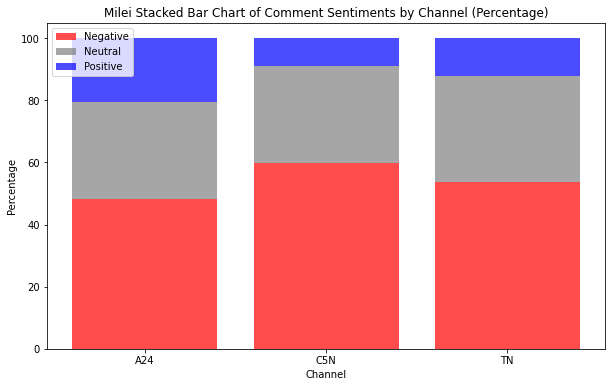

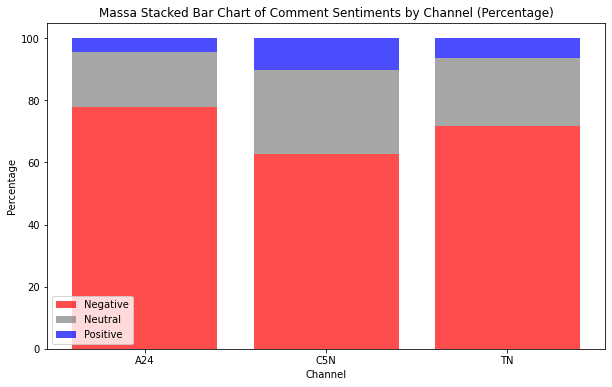

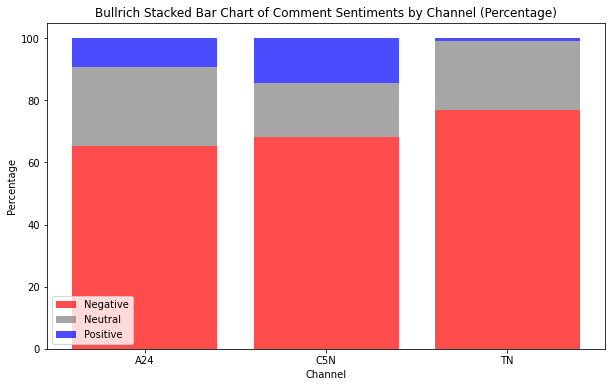

In [169]:
sentiment_per_party(lla_words, "Milei")
sentiment_per_party(k_words, "Massa")
sentiment_per_party(jxc_words, "Bullrich")

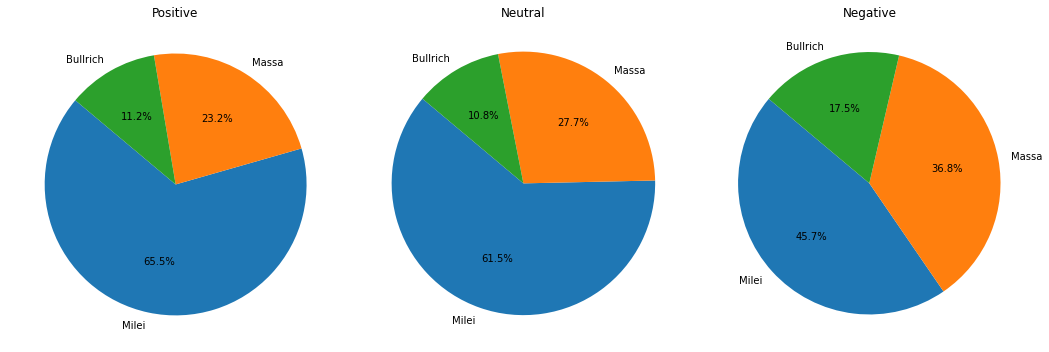

In [166]:
# Initialize counters
sentiments = {'positive': [0, 0, 0], 'neutral': [0, 0, 0], 'negative': [0, 0, 0]}

# Count sentiments for each group
for data, index in zip([milei_sentiment_per_channel, massa_sentiment_per_channel, bullrich_sentiment_per_channel], range(3)):
    for _, sentiment, count, _ in data:
        sentiments[sentiment][index] += count

# Plot pie charts
labels = ['Milei', 'Massa', 'Bullrich']

# Create a single figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

labels = ['Milei', 'Massa', 'Bullrich']

for ax, sentiment in zip(axes, ['positive', 'neutral', 'negative']):
    ax.pie(sentiments[sentiment], labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(sentiment.capitalize())
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie charts
plt.tight_layout()
plt.show()

In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
    return exp_x / exp_x.sum(axis=0)

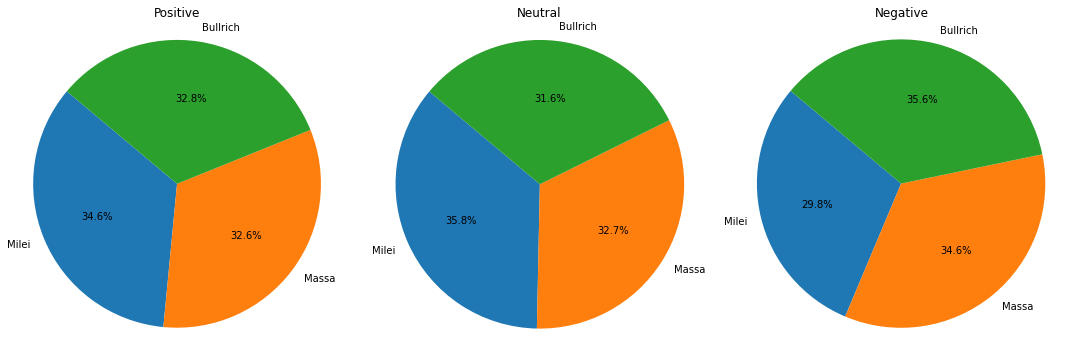

In [163]:
# Initialize counters
sentiments = {'positive': [0, 0, 0], 'neutral': [0, 0, 0], 'negative': [0, 0, 0]}
total_count_per_candidate = [0, 0, 0]

# Count sentiments for each group
for data, index in zip([milei_sentiment_per_channel, massa_sentiment_per_channel, bullrich_sentiment_per_channel], range(3)):
    for _, sentiment, count, _ in data:
        sentiments[sentiment][index] += count
        total_count_per_candidate[index] += count

for index, cnt in enumerate(total_count_per_candidate):
    sentiments["positive"][index] /= cnt
    sentiments["neutral"][index] /= cnt
    sentiments["negative"][index] /= cnt

for key in sentiments:
    sentiments[key] = softmax(np.array(sentiments[key]))

# Create a single figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

labels = ['Milei', 'Massa', 'Bullrich']

for ax, sentiment in zip(axes, ['positive', 'neutral', 'negative']):
    ax.pie(sentiments[sentiment], labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(sentiment.capitalize())
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie charts
plt.tight_layout()
plt.show()

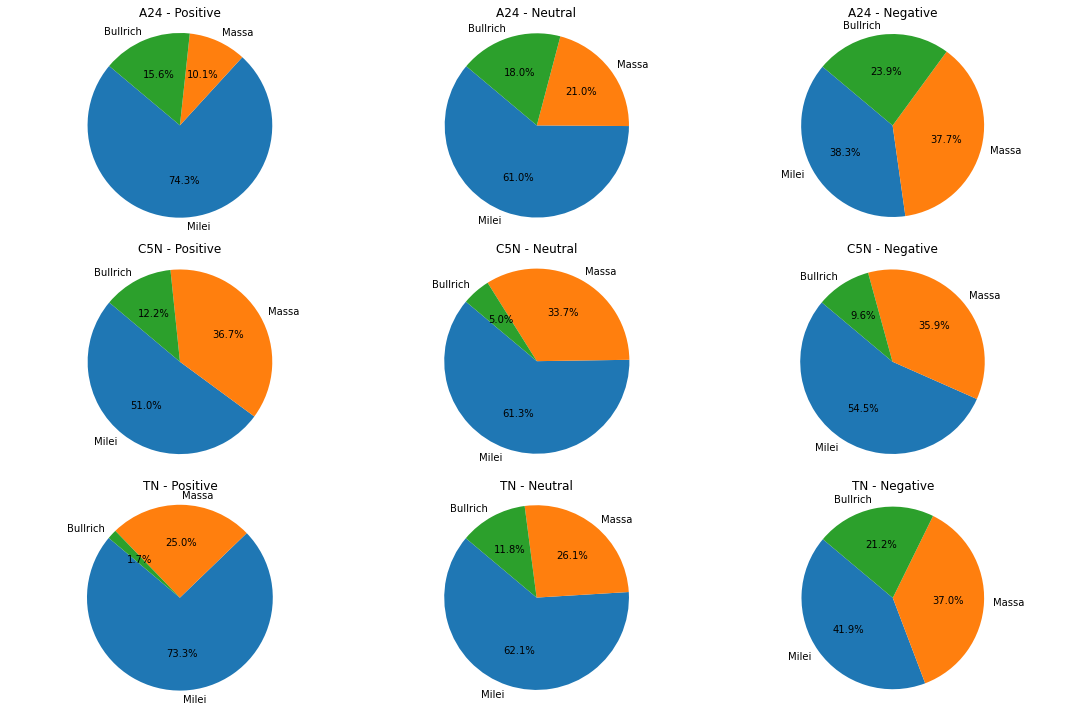

In [137]:
# Initialize counters
sentiments = {
    "A24": {'positive': [0, 0, 0], 'neutral': [0, 0, 0], 'negative': [0, 0, 0]},
    "C5N": {'positive': [0, 0, 0], 'neutral': [0, 0, 0], 'negative': [0, 0, 0]},
    "TN": {'positive': [0, 0, 0], 'neutral': [0, 0, 0], 'negative': [0, 0, 0]}
}

# Create subplots for each channel
fig, axs = plt.subplots(len(channels), len(sentiments), figsize=(15, 10))

# Count sentiments for each group
for data, index in zip([milei_sentiment_per_channel, massa_sentiment_per_channel, bullrich_sentiment_per_channel], range(3)):
    for channel, sentiment, count, _ in data:
        sentiments[channel][sentiment][index] += count

# Plot pie charts
labels = ['Milei', 'Massa', 'Bullrich']

for i, channel in enumerate(sentiments):
    for j, sentiment in enumerate(['positive', 'neutral', 'negative']):
        # Plot pie chart in the corresponding subplot
        axs[i, j].pie(sentiments[channel][sentiment], labels=labels, autopct='%1.1f%%', startangle=140)
        axs[i, j].set_title(f'{channel} - {sentiment.capitalize()}')
        axs[i, j].axis('equal')

# Adjust layout
plt.tight_layout()

# Show the pie charts
plt.show()

In [9]:
def make_df(result): 
    acc_columns = {x: [] for x in data.keys()}
    for x in result.result_rows:
        for curr_col, key in zip(x, data.keys()):
            acc_columns[key].append(curr_col)
            
    return pd.DataFrame(acc_columns)

## To Analyze

- look president up and see what they say
- main critics to each candidate -> kmeans
- Does it change with times?
- Does it change between channels?
- Sentiment between parties
- Amount of messages per candidate
- Clustering messages -> main bad things per candidate and main good things per candidate
- Word frequencies? -> Per time?
- Amount of messages per time?